## I went through line by line of the starter file to do the homework.
## Much of the optional problem was repetitive so I wrote some functions that would allow calling one function with parameters.
## The functions are presented and run below.
## The function is called MC_run. It takes in the parameters: portfolio, bnds, stocks, sims, yrs, and invest. 
## The parameters are explained in the comments near the function.
### MC_run calls three other functions (sim(Y), dist(Y), and stats_table(Y)).)

In [2]:
# Initial imports                                   #importing packages and libraries. 
import os
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools_2 import MCSimulation          #Note: I modified this python module to eliminate the long reporting of which iteration of MCMC the routine is on.
import matplotlib.pyplot as plt                     #Note: I added this import. It allows me to display plots using my MC_run function

%matplotlib inline

In [3]:
# Load .env enviroment variables
load_dotenv()                               #gets the  proper .env for me

True

In [4]:
# Set current amount of shares 
my_agg = 200
my_spy = 50

In [5]:
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")                        #gets the api key from .env
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")                  #gets the secret key from .env

# Create the Alpaca API object
alpaca = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")

### This next part brings in the stock data

In [12]:
# Set start and end dates of five years back from today.
# Sample results may vary from the solution based on the time frame chosen
start_date = pd.Timestamp('2016-05-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2021-05-01', tz='America/New_York').isoformat()
# Set the tickers
tickers = ["AGG", "SPY"]
# Set timeframe to "1Day" for Alpaca API
timeframe = "1Day"

In [13]:
# Get 5 years' worth of historical data for SPY and AGG
# YOUR CODE HERE!
df_stock_data = alpaca.get_bars(tickers, timeframe, start= start_date, end= end_date).df
# Reorganize the DataFrame
# Separate ticker data
# YOUR CODE HERE!
AGG = df_stock_data[df_stock_data["symbol"]== "AGG"].drop("symbol", axis=1)
SPY = df_stock_data[df_stock_data["symbol"]== "SPY"].drop("symbol", axis=1)

# Concatenate the ticker DataFrames
# YOUR CODE HERE!
df_stock_data = pd.concat([AGG, SPY], axis=1, keys=["AGG", "SPY"])
# Display sample data
df_stock_data.head()

AGG                                       \
                             open      high       low   close   volume   
timestamp                                                                
2016-05-02 04:00:00+00:00  110.74  110.7400  110.5200  110.61  3553939   
2016-05-03 04:00:00+00:00  110.89  110.9450  110.7500  110.81  3044940   
2016-05-04 04:00:00+00:00  110.91  110.9315  110.7595  110.86  2920608   
2016-05-05 04:00:00+00:00  110.92  111.1600  110.8010  111.14  3008142   
2016-05-06 04:00:00+00:00  111.12  111.1200  110.9700  110.97  2718710   

                                                      SPY                  \
                          trade_count        vwap    open    high     low   
timestamp                                                                   
2016-05-02 04:00:00+00:00       15119  110.627199  206.90  208.18  206.41   
2016-05-03 04:00:00+00:00       15662  110.865995  206.50  206.80  205.28   
2016-05-04 04:00:00+00:00       13982  110.879063  205.00  205.85  204.42   
2016-05-05 04:00:00+00:00       15707  111.028363  205.57  205.98  204.47   
2016-05-06 04:00:00+00:00       12697  111.031967  204.04  205.77  203.88   

                                                                      
                            close     volume trade_count        vwap  
timestamp                                                             
2016-05-02 04:00:00+00:00  208.03   61908515      263580  207.294812  
2016-05-03 04:00:00+00:00  206.13  106422142      377518  206.312060  
2016-05-04 04:00:00+00:00  204.96   92199810      345261  205.090172  
2016-05-05 04:00:00+00:00  204.95   67597222      280622  205.141555  
2016-05-06 04:00:00+00:00  205.70   89131004      340335  204.937074

### Now I set up the functions to do the retirement planning analysis

In [14]:
# Instead of repeatedly typing all of that code over and over, I set up some functions so that I can get the answers
# from typing a single function call.

# Function MC_run is to be called with variables:
# portfolio: Reference to the dataframe containing the stock data
# bnds: Propotion of bonds in the portfolio.
# stocks: Proportion of stocks in the portfolio
## Note: my data frame is set up to contain bonds first (AGG) and stocks second (SPY) ##
# sims: the number of simulation iterations
# yrs: the number of years over which to project returns
# invest: the initial investment

def MC_run(portfolio, bnds, stocks, sims, yrs, invest):
    MC_X = MCSimulation(                                        #Configuring the Monte Carlo simulation.
        portfolio_data= portfolio,
          weights=[bnds, stocks],
           num_simulation=sims,
            num_trading_days=252*yrs
            )
    MC_X.calc_cumulative_return()                               #Running the Monte Carlo simulation
    sim(MC_X)                                                   #Calls the sim(Y) function: plot_simulation()
    dist(MC_X) 
    global table                                                #Making the variable 'table' global so that I can use the stats table in the second part of the homework question.
    table = stats_table(MC_X)                                   #Calls the dist(Y) function: plot_distribution()
    ci_lower_mc = round(table[8] * invest, 2)                   #Calls the stats_table function and assigns the returned Series to the variable 'table'.
    ci_upper_mc = round(table[9] * invest, 2)                   #Calculations of lower and upper 95% CI. I had to ad the _mc to make the variable unique in this workbook.
    
                                                                #Final message is printed:
    print(f'\nThere is a 95% chance that an initial investment of ${invest} in the portfolio\n\
over the next {yrs} years will end within in the range of $ {ci_lower_mc} and $ {ci_upper_mc}')

    
def sim(Y):                                                     #Called by MC_run function.
    Y.plot_simulation()                                         #plots simulation outcomes.
    plt.show()                                                  #Displays the plot. It is necessary to include "import matplotlib.pyplot as plt" in the initial imports.

def dist(Y):                                                    #Called by MC_run function
    Y.plot_distribution()                                       #plots distribution of outcomes.
    plt.show()                                                  #Displays the plot.

def stats_table(Y):                                             #Called by MC_run function.
    table = Y.summarize_cumulative_return()                     #Series of summary statistics is assigned to the variable 'table'
    print(f'Summary Statistics\n\
    {table}')
    return table                                                #The summary statistics table is printed and then the variable 'table' is returned to the MC_run function.

# Homework Part 2 - Retirement Planning
### Lets start by using my function to re-run the required Retirement Planning part of the homework!

/Users/richardmelvin/UofM-VIRT-FIN-PT-03-2022-U-LOL-1/02-Homework/05-APIs/Instructions/Starter_Code/MCForecastTools_2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


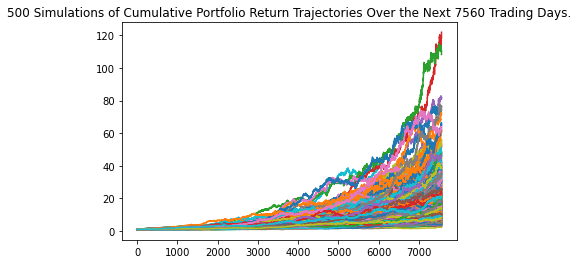

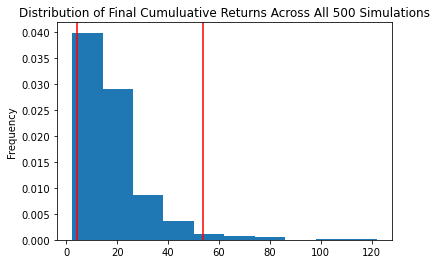

Summary Statistics
    count           500.000000
mean             18.644802
std              13.750820
min               2.300376
25%              10.019015
50%              15.160557
75%              22.969090
max             121.893192
95% CI Lower      4.287932
95% CI Upper     53.828108
Name: 7560, dtype: float64

There is a 95% chance that an initial investment of $20000 in the portfolio
over the next 30 years will end within in the range of $ 85758.64 and $ 1076562.16


In [15]:
MC_run(df_stock_data, .4, .6, 500, 30, 20000)  #Calling the MC_run function with parameters. Note: there is a PerformanceWarning that will print and that I am not sure of how to prevent.

### The required homework then asks for the estimated returns on a $30,000 initial investment.

In [16]:
# Set initial investment
initial_investment = 20000 * 1.5

# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes of our $30,000
# YOUR CODE HERE!
ci_lower_mc = round(table[8] * initial_investment, 2)
ci_upper_mc = round(table[9] * initial_investment, 2)
# Print results
print(f"There is a 95% chance that an initial investment of ${initial_investment} in the portfolio"
      f" over the next 30 years will end within in the range of"
      f" ${ci_lower_mc} and ${ci_upper_mc}")

There is a 95% chance that an initial investment of $30000.0 in the portfolio over the next 30 years will end within in the range of $128637.96 and $1614843.24


# Optional Challenge!
## 1. Higher Risk
### $20,000 initial investment, 10% bonds, 90% stocks, 5 years to redemption.

/Users/richardmelvin/UofM-VIRT-FIN-PT-03-2022-U-LOL-1/02-Homework/05-APIs/Instructions/Starter_Code/MCForecastTools_2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


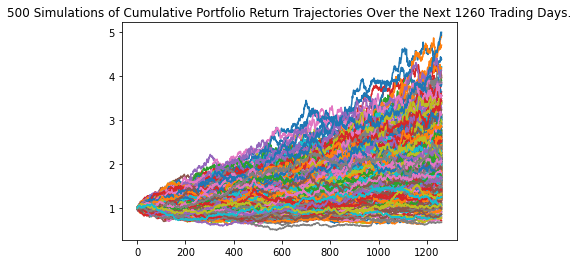

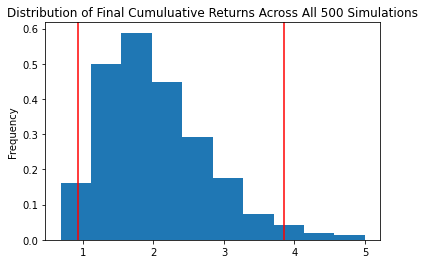

Summary Statistics
    count           500.000000
mean              2.027661
std               0.737219
min               0.681533
25%               1.475632
50%               1.902507
75%               2.435739
max               4.998857
95% CI Lower      0.931905
95% CI Upper      3.855107
Name: 1260, dtype: float64

There is a 95% chance that an initial investment of $20000 in the portfolio
over the next 5 years will end within in the range of $ 18638.09 and $ 77102.15


In [17]:
MC_run(df_stock_data, .1, .9, 500, 5, 20000)

## 2. Higher Risk
### $20,000 initial investment, 10% bonds, 90% stocks, 10 years to redemption.

/Users/richardmelvin/UofM-VIRT-FIN-PT-03-2022-U-LOL-1/02-Homework/05-APIs/Instructions/Starter_Code/MCForecastTools_2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


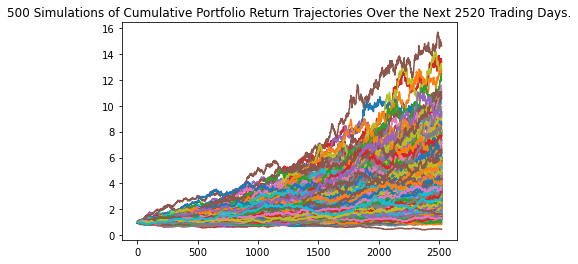

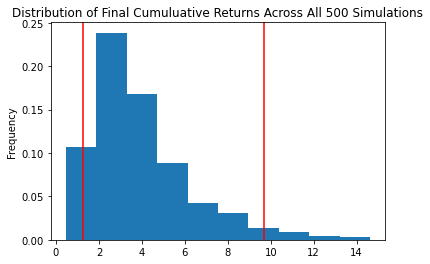

Summary Statistics
    count           500.000000
mean              3.933881
std               2.295952
min               0.456034
25%               2.305735
50%               3.323466
75%               4.943264
max              14.627421
95% CI Lower      1.252063
95% CI Upper      9.677440
Name: 2520, dtype: float64

There is a 95% chance that an initial investment of $20000 in the portfolio
over the next 10 years will end within in the range of $ 25041.25 and $ 193548.8


In [18]:
MC_run(df_stock_data, .1, .9, 500, 10, 20000)

## 3. Higher Risk
### $20,000 initial investment, 10% bonds, 90% stocks, 30 years to redemption.

/Users/richardmelvin/UofM-VIRT-FIN-PT-03-2022-U-LOL-1/02-Homework/05-APIs/Instructions/Starter_Code/MCForecastTools_2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


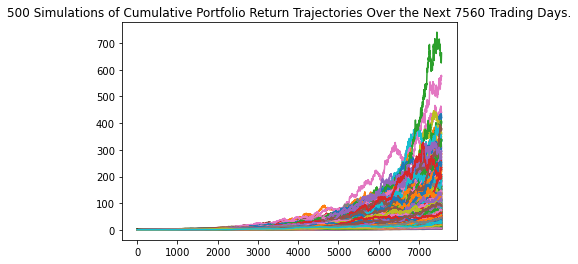

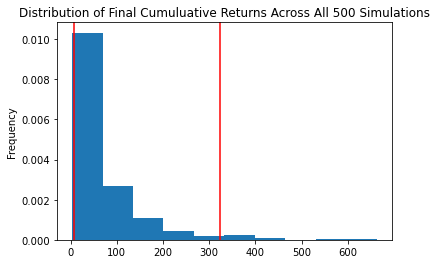

Summary Statistics
    count           500.000000
mean             72.829600
std              80.744441
min               3.423626
25%              25.053162
50%              47.156457
75%              85.944382
max             662.030893
95% CI Lower      7.228476
95% CI Upper    323.374572
Name: 7560, dtype: float64

There is a 95% chance that an initial investment of $20000 in the portfolio
over the next 30 years will end within in the range of $ 144569.52 and $ 6467491.45


In [19]:
MC_run(df_stock_data, .1, .9, 500, 30, 20000)

## 4. Greater Initial Investment
### $60,000 initial investment, 40% bonds, 60% stocks, 5 years to redemption.

/Users/richardmelvin/UofM-VIRT-FIN-PT-03-2022-U-LOL-1/02-Homework/05-APIs/Instructions/Starter_Code/MCForecastTools_2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


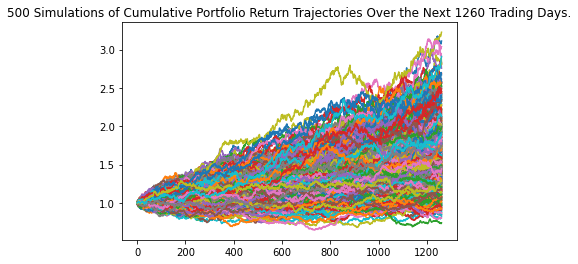

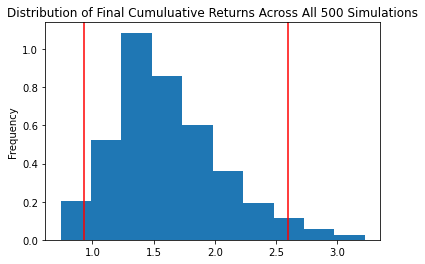

Summary Statistics
    count           500.000000
mean              1.612847
std               0.438335
min               0.739421
25%               1.301012
50%               1.543703
75%               1.856517
max               3.225362
95% CI Lower      0.928643
95% CI Upper      2.600168
Name: 1260, dtype: float64

There is a 95% chance that an initial investment of $60000 in the portfolio
over the next 5 years will end within in the range of $ 55718.55 and $ 156010.07


In [20]:
MC_run(df_stock_data, .4, .6, 500, 5, 60000)

## 5. Greater Initial Investment
### $60,000 initial investment, 40% bonds, 60% stocks, 10 years to redemption.

/Users/richardmelvin/UofM-VIRT-FIN-PT-03-2022-U-LOL-1/02-Homework/05-APIs/Instructions/Starter_Code/MCForecastTools_2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


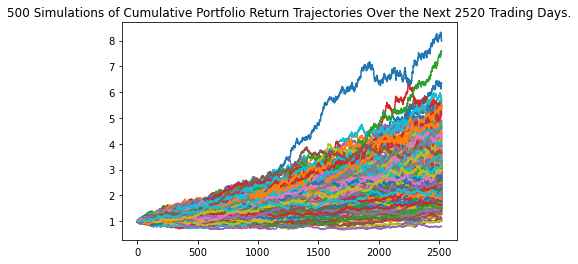

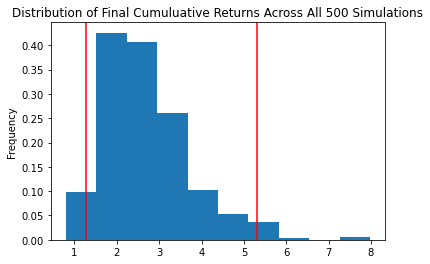

Summary Statistics
    count           500.000000
mean              2.692512
std               1.029039
min               0.795352
25%               1.949820
50%               2.508641
75%               3.209422
max               7.979783
95% CI Lower      1.283861
95% CI Upper      5.305488
Name: 2520, dtype: float64

There is a 95% chance that an initial investment of $60000 in the portfolio
over the next 10 years will end within in the range of $ 77031.64 and $ 318329.25


In [21]:
MC_run(df_stock_data, .4, .6, 500, 10, 60000)               #updated parameter yrs to 10

## 6. Greater Initial Investment
### $60,000 initial investment, 40% bonds, 60% stocks, 30 years to redemption.

/Users/richardmelvin/UofM-VIRT-FIN-PT-03-2022-U-LOL-1/02-Homework/05-APIs/Instructions/Starter_Code/MCForecastTools_2.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


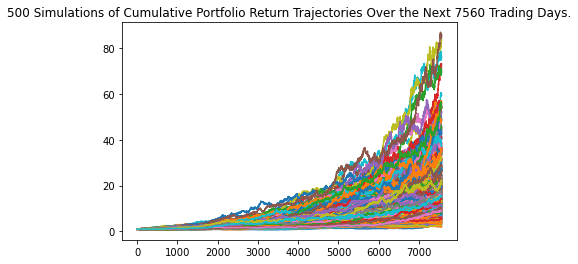

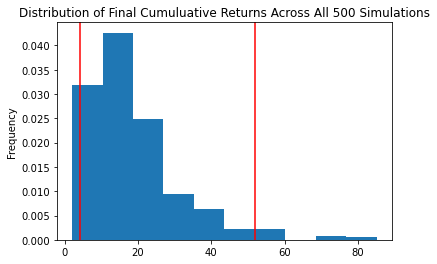

Summary Statistics
    count           500.000000
mean             18.402046
std              12.332167
min               2.026259
25%               9.793795
50%              15.407453
75%              22.780069
max              85.078295
95% CI Lower      4.223294
95% CI Upper     51.956457
Name: 7560, dtype: float64

There is a 95% chance that an initial investment of $60000 in the portfolio
over the next 30 years will end within in the range of $ 253397.62 and $ 3117387.44


In [22]:
MC_run(df_stock_data, .4, .6, 500, 30, 60000)               #updated parameter yrs to 30